# Keypoint regression

Single keypoint regression consists of localizing a keypoint in an image. Here we'll be training on a head pose dataset, where every image has a person in it and the head of the person is annotated. Since keypoint datasets all have different formats, we have to do a bit more manual work to get the task dataset loaded. First we import everything we'll need:

In [ ]:
using CairoMakie
using DataAugmentation
using DelimitedFiles: readdlm
using DLPipelines
using FastAI
using FastAI.Datasets
using FilePathsBase
using FilePathsBase: /
using Images
using StaticArrays

## Creating a task data container

[`datasetpath`](#) downloads the files, but it's up to us to load them into a usable format. In the end, the task data container should contain tuples of an image and a keypoint each.

In [4]:
path = datasetpath("biwi_head_pose")

p"/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose"

First we create a [`FileDataset`](#) from the directory where the dataset has been downloaded to:

In [5]:
pathdata_base = FileDataset(path)

FileDataset("/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose", 31430 observations)

A `FileDataset` simply treats every file as a single observation. However, that is not what we want here: for every observation we have one image and one annotation file that make up one observation and we want to ignore all other files, like the README. To achieve this, we'll create two data containers containing all the image paths and annotation paths respectively by filtering the container with all paths. 

In [6]:
pathdataimages = filterobs(isimagefile, pathdata_base)
pathdatannots = filterobs(pathdata_base) do p
    occursin("pose", filename(p))
end
pathdata = (pathdataimages, pathdatannots)
getobs(pathdata, 1)

(p"/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00003_rgb.jpg", p"/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00003_pose.txt")

Next we need to map functions over each observation that load the data from the files. An image file can be loaded using the [`loadfile`](#) utility. The keypoints have a custom format, so we write a helper function to parse them from a text file. 

In [7]:
readcalibrationfile(p) = readdlm(string(p))[1:3, 1:3]

CAL = readcalibrationfile(path / "01" / "rgb.cal")

function readannotfile(annotpath, cal = CAL)
    ctr = readdlm(string(annotpath))[4,:]
    cx = ctr[1] * cal[1,1]/ctr[3] + cal[1,3]
    cy = ctr[2] * cal[2,2]/ctr[3] + cal[2,3]
    return SVector(cy, cx) .+ 1
end

readannotfile (generic function with 2 methods)

Now we can use [`mapobs`](#) to lazily map the loading function over the container. By specifying a named tuple of functions, the result will be a container of named tuples as well. Note that beside loading the image and keypoint, we also extract the subject ID from the path. We'll use this in a bit for splitting the dataset appropriately and we don't have access to the path information anymore once we have a container of loaded data. 

In [8]:
taskdata = mapobs(
    (
        input = ((ip, ap),) -> loadfile(ip),
        target = ((ip, ap),) -> readannotfile(ap),
        subjectid = ((ip, ap),) -> parse(Int, filename(parent(ip)))
    ),
    pathdata)

mapobs((input = var"#3#6"(), target = var"#4#7"(), subjectid = var"#5#8"()), (DataSubset(::FileDataset, ::Vector{Int64}, ObsDim.Undefined())
 15678 observations, DataSubset(::FileDataset, ::Vector{Int64}, ObsDim.Undefined())
 15678 observations))

In [9]:
obs = getobs(taskdata, 1000)

(input = RGB{N0f8}[RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.008,0.008,0.008) … RGB{N0f8}(0.047,0.024,0.031) RGB{N0f8}(0.016,0.0,0.0); RGB{N0f8}(0.047,0.047,0.047) RGB{N0f8}(0.906,0.906,0.906) … RGB{N0f8}(0.553,0.529,0.537) RGB{N0f8}(0.067,0.043,0.051); … ; RGB{N0f8}(0.004,0.0,0.016) RGB{N0f8}(0.004,0.0,0.0) … RGB{N0f8}(0.475,0.451,0.451) RGB{N0f8}(0.059,0.039,0.027); RGB{N0f8}(0.004,0.0,0.016) RGB{N0f8}(0.004,0.0,0.0) … RGB{N0f8}(0.059,0.035,0.035) RGB{N0f8}(0.016,0.0,0.0)], target = [259.87126116345524, 401.78323834119755], subjectid = 2)

We can visualize an observation using [`DataAugmentation.showitems`](#) if we wrap the data in item types:

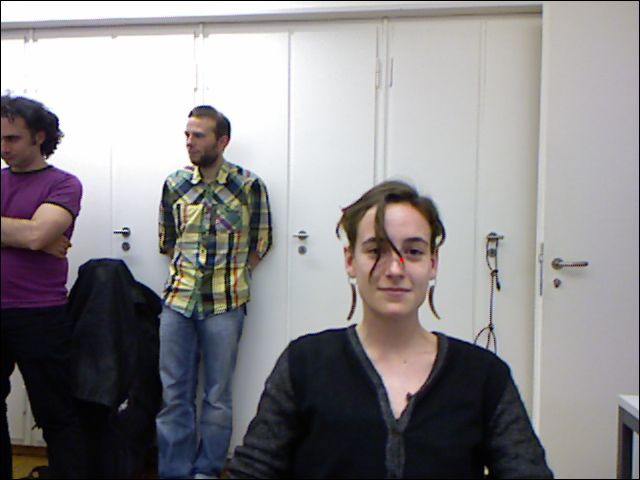

In [10]:
showitems((DataAugmentation.Image(obs.input), Keypoints([obs.target], size(obs.input))))

Before we can start using this data container for training, we need to split into a training and validation dataset. Since there are 13 different persons with many images each, randomly splitting the container does not make sense. The validation dataset would then contain many images that are very similar to those seen in training, and would hence say little about the generalization ability of a model. We instead use the first 12 subjects as a training dataset and validate on the last.

In [11]:
ids = [getobs(taskdata.subjectid, i) for i in 1:nobs(taskdata)]
traindata = datasubset(taskdata, (1:nobs(taskdata))[ids .!= 13])
validdata = datasubset(taskdata, (1:nobs(taskdata))[ids .== 13])
nobs(traindata), nobs(validdata)

(15193, 485)

## The learning method

The learning method [`SingleKeypointRegression`](#) takes care of augmenting and preprocessing the data, so that we can train a model on it.

In [15]:
sz = (128, 128)
method = SingleKeypointRegression(
    sz,
    ProjectiveTransforms(sz, augmentations=augs_projection(max_warp=0., max_rotate=0.)),
    ImagePreprocessing())

SingleKeypointRegression{2}((128, 128), ProjectiveTransforms((128, 128)), ImagePreprocessing())

We can check that each image is resized to `(128, 128)` and the keypoints are normalized:

In [18]:
x, y = encode(method, Training(), getobs(traindata, 1))
summary(x), y

("128×128×3 Array{Float32, 3}", Float32[0.10481223, -0.18196905])

Let's also check that the keypoints and images are still aligned after the augmentations:

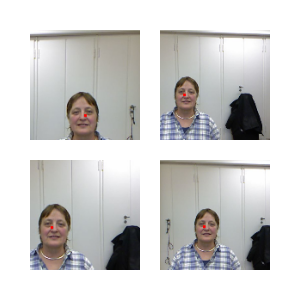

In [24]:
xs, ys = FastAI.makebatch(method, traindata, 1:4)
FastAI.plotbatch!(Figure(resolution=(300, 300)), method, xs, ys)

And finally finetune a pretrained model on the dataset. See [the setup instructions](../setup.md) for installing the correct version of Metalhead.jl.

In [38]:
using Metalhead

In [39]:
backbone = Metalhead.resnet50(pretrain=true)[1:end-3]
learner = methodlearner(
    method,
    traindata,
    backbone,
    ToGPU();
    validdata=validdata)

Learner()

In [40]:
finetune!(learner, 3)

Epoch 1 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:24


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   1.0 │ 0.09179 │
└───────────────┴───────┴─────────┘


Epoch 1 ValidationPhase(): 100%|████████████████████████| Time: 0:00:05


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   1.0 │ 0.00878 │
└─────────────────┴───────┴─────────┘


Epoch 2 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:42


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   2.0 │ 0.03243 │
└───────────────┴───────┴─────────┘


Epoch 2 ValidationPhase(): 100%|████████████████████████| Time: 0:00:10


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   2.0 │ 0.01161 │
└─────────────────┴───────┴─────────┘


Epoch 3 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:34


┌───────────────┬───────┬────────┐
│         Phase │ Epoch │   Loss │
├───────────────┼───────┼────────┤
│ TrainingPhase │   3.0 │ 0.0239 │
└───────────────┴───────┴────────┘


Epoch 3 ValidationPhase(): 100%|████████████████████████| Time: 0:00:04


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   3.0 │ 0.00236 │
└─────────────────┴───────┴─────────┘


Epoch 4 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:30


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   4.0 │ 0.01169 │
└───────────────┴───────┴─────────┘


Epoch 4 ValidationPhase(): 100%|████████████████████████| Time: 0:00:10


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   4.0 │ 0.00146 │
└─────────────────┴───────┴─────────┘


Learner()

Finally we can visualize the results of the trained model on a batch from the validation dataset:

In [49]:
xs, ys = FastAI.makebatch(method, validdata, rand(1:485, 16), context = Validation())
ŷs = learner.model(gpu(xs)) |> cpu

2×16 Matrix{Float32}:
  0.0698397    0.00673294  0.0304189  …  0.022421  0.0228257  -0.000985444
 -0.000130892  0.088009    0.114407      0.282444  0.150855    0.201167

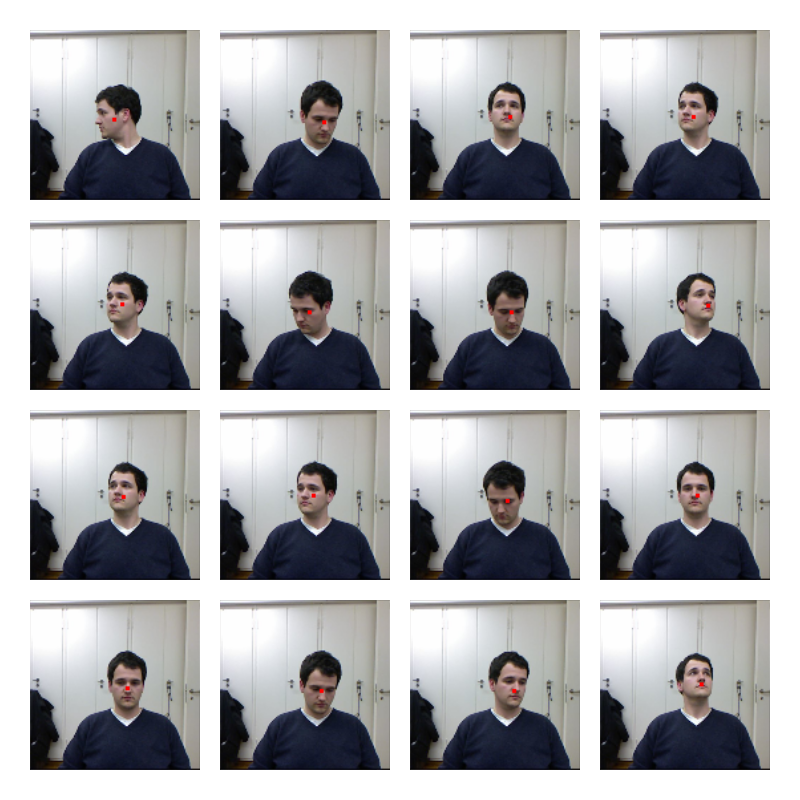

In [58]:
f = FastAI.plotbatch(method, xs, cpu(ŷs))